In [14]:
import os
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from zipfile import ZipFile
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import os
import requests
import zipfile
import os
import urllib.request as urllib2
from bs4 import BeautifulSoup
import re
from pathlib import Path


In [15]:
# Kaggle paths
RAW_DIR   = Path("/kaggle/input/airfoil/data")
WORK_DIR  = Path("/kaggle/working/data")
WORK_DIR.mkdir(parents=True, exist_ok=True)

for fname in ["xs_train.npy", "xs_test.npy", "ys_train.npy", "ys_test.npy"]:
    !cp $RAW_DIR/$fname $WORK_DIR/$fname


In [16]:
DATA_DIR = Path("/kaggle/working/data")

xs_train = np.load(DATA_DIR/"xs_train.npy")
xs_test  = np.load(DATA_DIR/"xs_test.npy")
ys_train = np.load(DATA_DIR/"ys_train.npy")
ys_test  = np.load(DATA_DIR/"ys_test.npy")

print("Train shapes:", xs_train.shape, ys_train.shape)
print("Test  shapes:", xs_test.shape , ys_test.shape)


Train shapes: (38802, 192, 2) (38802, 2)
Test  shapes: (9701, 192, 2) (9701, 2)


In [17]:
# compute train mins / maxes
x_min, x_max = xs_train[...,0].min(), xs_train[...,0].max()
y_min, y_max = xs_train[...,1].min(), xs_train[...,1].max()

# scale
xs_train_s = xs_train.copy()
xs_test_s  = xs_test.copy()
xs_train_s[...,0] = (xs_train[...,0] - x_min) / (x_max - x_min)
xs_train_s[...,1] = (xs_train[...,1] - y_min) / (y_max - y_min)
xs_test_s[...,0]  = (xs_test [...,0] - x_min) / (x_max - x_min)
xs_test_s[...,1]  = (xs_test [...,1] - y_min) / (y_max - y_min)

# save arrays + min/max
np.save(DATA_DIR/"xs_train_scaled.npy", xs_train_s)
np.save(DATA_DIR/"xs_test_scaled.npy",  xs_test_s)
np.save(DATA_DIR/"coord_min_max.npy",   np.array([[x_min, y_min],
                                                 [x_max, y_max]]))


In [18]:
cl_min, cl_max = ys_train[:,0].min(), ys_train[:,0].max()
cd_min, cd_max = ys_train[:,1].min(), ys_train[:,1].max()

ys_train_s = (ys_train - np.array([cl_min, cd_min])) / np.array([cl_max-cl_min,
                                                                 cd_max-cd_min])
ys_test_s  = (ys_test  - np.array([cl_min, cd_min])) / np.array([cl_max-cl_min,
                                                                 cd_max-cd_min])

# save
np.save(DATA_DIR/"ys_train_scaled.npy", ys_train_s)
np.save(DATA_DIR/"ys_test_scaled.npy",  ys_test_s)
np.save(DATA_DIR/"label_min_max.npy",   np.array([[cl_min, cd_min],
                                                 [cl_max, cd_max]]))


In [27]:
import torch
from torch.utils.data import Dataset

class AirfoilDataset(Dataset):
    def __init__(self,
                 xs_scaled_path,
                 ys_scaled_path,
                 coord_min_max_path,
                 label_min_max_path):
        self.xs = np.load(xs_scaled_path).astype(np.float32)   # (N,192,2)
        self.ys = np.load(ys_scaled_path).astype(np.float32)   # (N,2)

        coord_mm = np.load(coord_min_max_path)
        label_mm = np.load(label_min_max_path)

        self.x_min,  self.y_min  = coord_mm[0]
        self.x_max,  self.y_max  = coord_mm[1]
        self.cl_min, self.cd_min = label_mm[0]
        self.cl_max, self.cd_max = label_mm[1]

    def __len__(self):
        return len(self.xs)

    def __getitem__(self, idx):
        coords = torch.from_numpy(self.xs[idx].T)      # (2,192)
        cl, cd = self.ys[idx]
        return coords, torch.tensor([cl, cd], dtype=torch.float32)

    def inverse_scale_coords(self, xs_s):
        """
        xs_s : (..., 192, 2) or (..., 2, 192)  tensor **or** numpy
               If shape is (...,2,192) we treat axis 1 as (x,y) and transpose.
        returns numpy array in physical units, shape (...,192,2)
        """
        # to numpy
        xs_np = xs_s.detach().cpu().numpy() if torch.is_tensor(xs_s) else np.asarray(xs_s)
        # ensure last dim==2
        if xs_np.shape[-2] == 2 and xs_np.shape[-1] == 192:   # (B,2,192)
            xs_np = np.transpose(xs_np, (0,2,1))              # -> (B,192,2)
        xs = xs_np.copy()
        xs[...,0] = xs[...,0]*(self.x_max - self.x_min) + self.x_min
        xs[...,1] = xs[...,1]*(self.y_max - self.y_min) + self.y_min
        return xs                                                 # (B,192,2)

    def inverse_scale_labels(self, ys_s):
        ys_np = ys_s.detach().cpu().numpy() if torch.is_tensor(ys_s) else np.asarray(ys_s)
        cl = ys_np[...,0]*(self.cl_max - self.cl_min) + self.cl_min
        cd = ys_np[...,1]*(self.cd_max - self.cd_min) + self.cd_min
        return np.stack([cl, cd], axis=-1)

In [28]:
# === DATASET + LOADER =====================================================
from torch.utils.data import DataLoader
from pathlib import Path

DATA_DIR = Path("/kaggle/working/data")

train_ds = AirfoilDataset(
    xs_scaled_path      = DATA_DIR/"xs_train_scaled.npy",
    ys_scaled_path      = DATA_DIR/"ys_train_scaled.npy",
    coord_min_max_path  = DATA_DIR/"coord_min_max.npy",
    label_min_max_path  = DATA_DIR/"label_min_max.npy"
)

BATCH_SIZE   = 128
NUM_WORKERS  = 2           # Kaggle usually has 2 CPUs
PIN_MEMORY   = True        # copy tensors to pinned host memory → faster GPU transfer

loader = DataLoader(
    train_ds,
    batch_size      = BATCH_SIZE,
    shuffle         = True,
    drop_last       = True,
    num_workers     = NUM_WORKERS,
    pin_memory      = PIN_MEMORY,
    persistent_workers = True      # keeps workers alive across epochs
)

print("one batch shapes:", next(iter(loader))[0].shape)


one batch shapes: torch.Size([128, 2, 192])



### Label distributions (train) ###


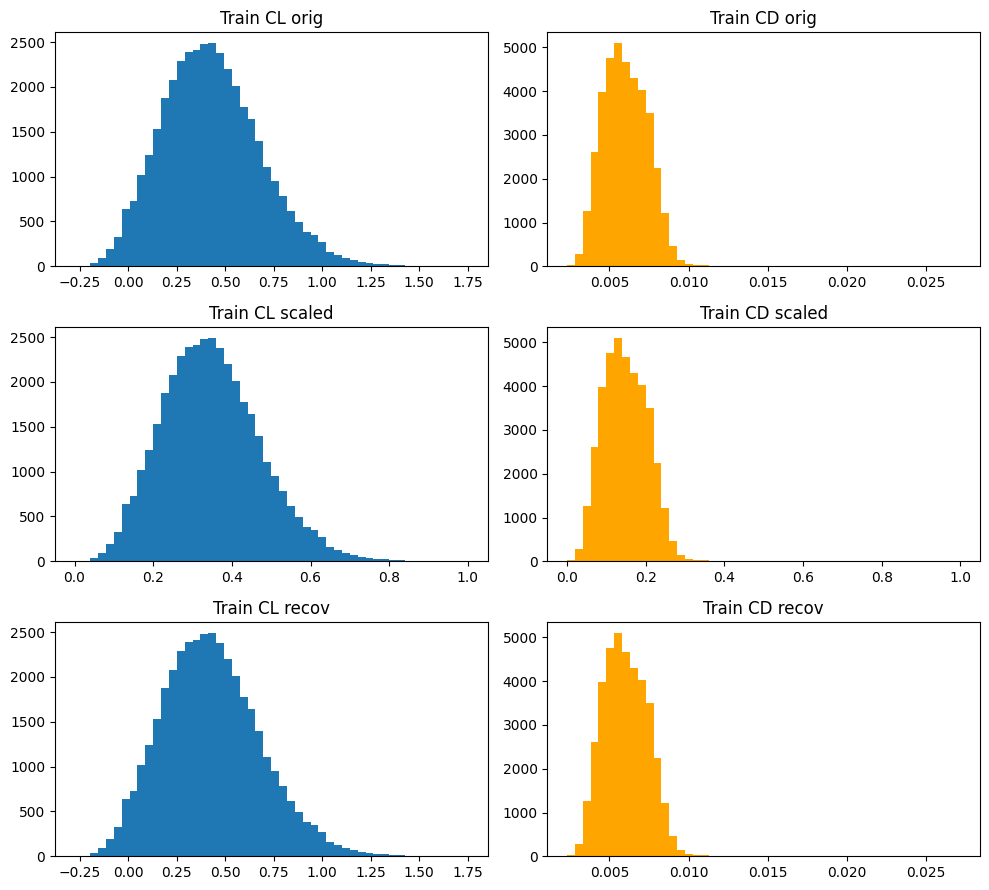


### Coordinate signatures (train) ###


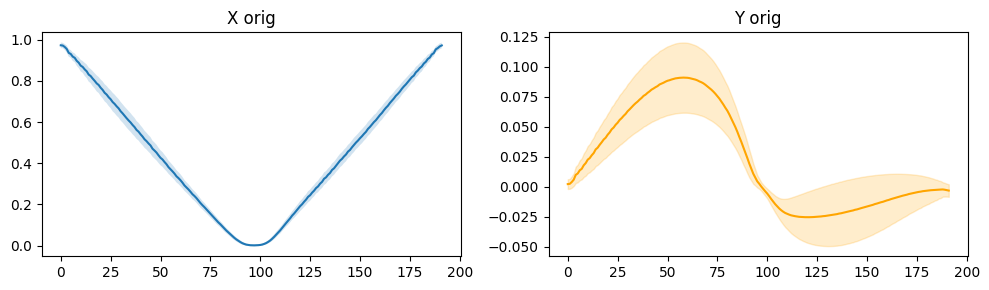

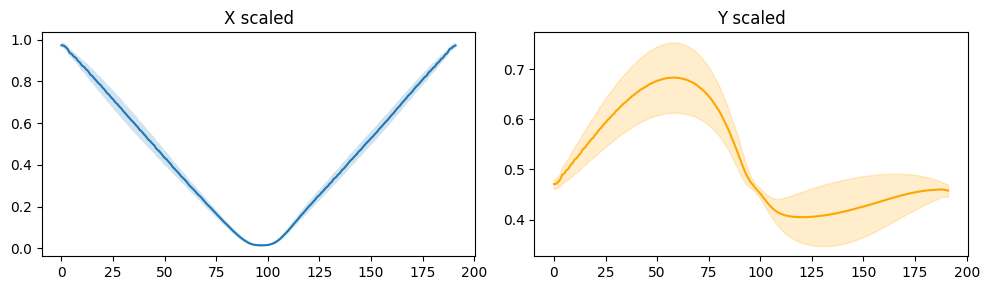

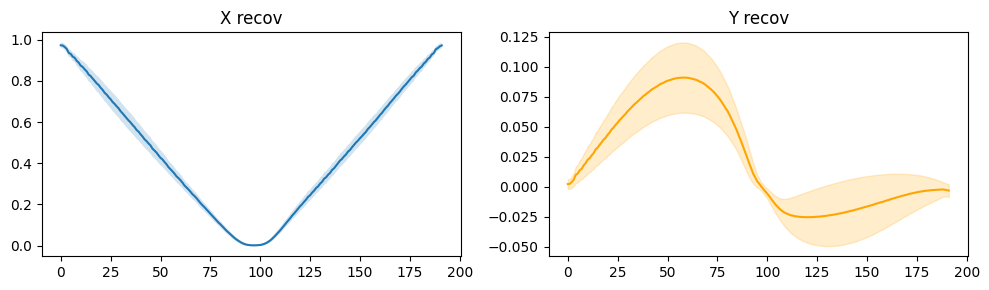

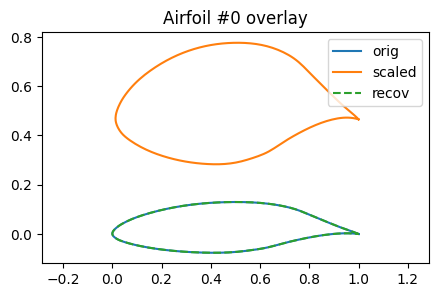

In [29]:
# === Sanity-plots for scaled ↔ unscaled data ==============================
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

DATA_DIR = Path("/kaggle/working/data")

# --- load everything we need
xs_train        = np.load(DATA_DIR/"xs_train.npy")
xs_train_scaled = np.load(DATA_DIR/"xs_train_scaled.npy")
ys_train        = np.load(DATA_DIR/"ys_train.npy")
ys_train_scaled = np.load(DATA_DIR/"ys_train_scaled.npy")

coord_mm = np.load(DATA_DIR/"coord_min_max.npy")   # [[x_min,y_min],[x_max,y_max]]
label_mm = np.load(DATA_DIR/"label_min_max.npy")   # [[cl_min,cd_min],[cl_max,cd_max]]
x_min,y_min = coord_mm[0]; x_max,y_max = coord_mm[1]
cl_min,cd_min = label_mm[0]; cl_max,cd_max = label_mm[1]

# --- inverse helpers
def inv_coords(x_s):
    out = np.empty_like(x_s)
    out[...,0] = x_s[...,0]*(x_max-x_min)+x_min
    out[...,1] = x_s[...,1]*(y_max-y_min)+y_min
    return out

def inv_labels(y_s):
    out = np.empty_like(y_s)
    out[:,0] = y_s[:,0]*(cl_max-cl_min)+cl_min
    out[:,1] = y_s[:,1]*(cd_max-cd_min)+cd_min
    return out

# sanity: should match original exactly
xs_train_recov = inv_coords(xs_train_scaled)
ys_train_recov = inv_labels(ys_train_scaled)

# -------------------------------------------------------------------------
# 1) label histograms CL / CD orig vs scaled vs recovered
def hist_compare(orig, scaled, recov, name):
    bins=50
    fig, ax = plt.subplots(3,2, figsize=(10,9))
    titles = [["CL orig","CD orig"],["CL scaled","CD scaled"],["CL recov","CD recov"]]
    arrays = [(orig[:,0],orig[:,1]),(scaled[:,0],scaled[:,1]),(recov[:,0],recov[:,1])]
    for r in range(3):
        ax[r,0].hist(arrays[r][0], bins); ax[r,0].set_title(f"{name} {titles[r][0]}")
        ax[r,1].hist(arrays[r][1], bins, color="orange"); ax[r,1].set_title(f"{name} {titles[r][1]}")
    plt.tight_layout(); plt.show()

print("\n### Label distributions (train) ###")
hist_compare(ys_train, ys_train_scaled, ys_train_recov, "Train")

# -------------------------------------------------------------------------
# 2) coordinate signature mean ± std orig vs scaled vs recovered
def coord_signature(xs, tag):
    mean_x, std_x = xs[...,0].mean(0), xs[...,0].std(0)
    mean_y, std_y = xs[...,1].mean(0), xs[...,1].std(0)
    fig, ax = plt.subplots(1,2, figsize=(10,3))
    ax[0].plot(mean_x); ax[0].fill_between(range(len(mean_x)), mean_x-std_x, mean_x+std_x, alpha=0.2)
    ax[0].set_title(f"X {tag}")
    ax[1].plot(mean_y, color="orange"); ax[1].fill_between(range(len(mean_y)), mean_y-std_y, mean_y+std_y, alpha=0.2,color="orange")
    ax[1].set_title(f"Y {tag}")
    plt.tight_layout(); plt.show()

print("\n### Coordinate signatures (train) ###")
coord_signature(xs_train,        "orig")
coord_signature(xs_train_scaled, "scaled")
coord_signature(xs_train_recov,  "recov")

# -------------------------------------------------------------------------
# 3) overlay of one sample (index 0)
i=0
orig  = xs_train[i]
scaled= xs_train_scaled[i]
recov = xs_train_recov[i]

plt.figure(figsize=(5,3))
plt.plot(orig[:,0],  orig[:,1],  label="orig")
plt.plot(scaled[:,0],scaled[:,1],label="scaled")
plt.plot(recov[:,0], recov[:,1], label="recov", ls="--")
plt.legend(); plt.axis('equal'); plt.title("Airfoil #0 overlay"); plt.show()


In [30]:
!pip install aerosandbox wandb accelerate ema-pytorch tqdm torch torchvision numpy matplotlib einops denoising-diffusion-pytorch


In [31]:
!mkdir -p /kaggle/working/model_weights/Simple_DDPM

In [32]:
import os
import math
from pathlib import Path
from random import random
from functools import partial
from collections import namedtuple
from multiprocessing import cpu_count

import torch
from torch import nn, einsum, Tensor
from torch.nn import Module, ModuleList
import torch.nn.functional as F
from torch.cuda.amp import autocast
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader

from einops import rearrange, reduce
from einops.layers.torch import Rearrange

from accelerate import Accelerator
from ema_pytorch import EMA

from tqdm.auto import tqdm

from denoising_diffusion_pytorch.version import __version__

# constants

ModelPrediction =  namedtuple('ModelPrediction', ['pred_noise', 'pred_x_start'])

model_save_dir = "/kaggle/working/model_weights/Simple_DDPM"
os.makedirs(model_save_dir, exist_ok=True)

# helpers functions

def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if callable(d) else d

def identity(t, *args, **kwargs):
    return t

def cycle(dl):
    while True:
        for data in dl:
            yield data

def has_int_squareroot(num):
    return (math.sqrt(num) ** 2) == num

def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr

def convert_image_to_fn(img_type, image):
    if image.mode != img_type:
        return image.convert(img_type)
    return image

# normalization functions

def normalize_to_neg_one_to_one(img):
    return img * 2 - 1

def unnormalize_to_zero_to_one(t):
    return (t + 1) * 0.5

# data

class Dataset1D(Dataset):
    def __init__(self, tensor: Tensor):
        super().__init__()
        self.tensor = tensor.clone()

    def __len__(self):
        return len(self.tensor)

    def __getitem__(self, idx):
        return self.tensor[idx].clone()

# small helper modules

class Residual(Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x
'''
def Upsample(dim, dim_out = None):
    return nn.Sequential(
        nn.Upsample(scale_factor = 2, mode = 'nearest'),
        nn.Conv1d(dim, default(dim_out, dim), 3, padding = 1)
    )

def Downsample(dim, dim_out = None):
    return nn.Conv1d(dim, default(dim_out, dim), 4, 2, 1)
'''

def Downsample(dim, dim_out=None):
    return nn.Sequential(
        nn.Conv1d(dim, default(dim_out, dim), 4, stride=2, padding=1)
    )

def Upsample(dim, dim_out=None):
    return nn.Sequential(
        nn.ConvTranspose1d(dim, default(dim_out, dim), 4, stride=2, padding=1, output_padding=1)
    )



class RMSNorm(Module):
    def __init__(self, dim):
        super().__init__()
        self.g = nn.Parameter(torch.ones(1, dim, 1))

    def forward(self, x):
        return F.normalize(x, dim = 1) * self.g * (x.shape[1] ** 0.5)

class PreNorm(Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = RMSNorm(dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)

# sinusoidal positional embeds

class SinusoidalPosEmb(Module):
    def __init__(self, dim, theta = 10000):
        super().__init__()
        self.dim = dim
        self.theta = theta

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(self.theta) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

class RandomOrLearnedSinusoidalPosEmb(Module):
    """ following @crowsonkb 's lead with random (learned optional) sinusoidal pos emb """
    """ https://github.com/crowsonkb/v-diffusion-jax/blob/master/diffusion/models/danbooru_128.py#L8 """

    def __init__(self, dim, is_random = False):
        super().__init__()
        assert (dim % 2) == 0
        half_dim = dim // 2
        self.weights = nn.Parameter(torch.randn(half_dim), requires_grad = not is_random)

    def forward(self, x):
        x = rearrange(x, 'b -> b 1')
        freqs = x * rearrange(self.weights, 'd -> 1 d') * 2 * math.pi
        fouriered = torch.cat((freqs.sin(), freqs.cos()), dim = -1)
        fouriered = torch.cat((x, fouriered), dim = -1)
        return fouriered

# building block modules

class Block(Module):
    def __init__(self, dim, dim_out, dropout = 0.):
        super().__init__()
        self.proj = nn.Conv1d(dim, dim_out, 3, padding = 1)
        self.norm = RMSNorm(dim_out)
        self.act = nn.SiLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, scale_shift = None):
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return self.dropout(x)

class ResnetBlock(Module):
    def __init__(self, dim, dim_out, *, time_emb_dim = None, dropout = 0.):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_emb_dim, dim_out * 2)
        ) if exists(time_emb_dim) else None

        self.block1 = Block(dim, dim_out, dropout = dropout)
        self.block2 = Block(dim_out, dim_out)
        self.res_conv = nn.Conv1d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb = None):

        scale_shift = None
        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            time_emb = rearrange(time_emb, 'b c -> b c 1')
            scale_shift = time_emb.chunk(2, dim = 1)

        h = self.block1(x, scale_shift = scale_shift)

        h = self.block2(h)

        return h + self.res_conv(x)

class LinearAttention(Module):
    def __init__(self, dim, heads = 4, dim_head = 32):
        super().__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv1d(dim, hidden_dim * 3, 1, bias = False)

        self.to_out = nn.Sequential(
            nn.Conv1d(hidden_dim, dim, 1),
            RMSNorm(dim)
        )

    def forward(self, x):
        b, c, n = x.shape
        qkv = self.to_qkv(x).chunk(3, dim = 1)
        q, k, v = map(lambda t: rearrange(t, 'b (h c) n -> b h c n', h = self.heads), qkv)

        q = q.softmax(dim = -2)
        k = k.softmax(dim = -1)

        q = q * self.scale

        context = torch.einsum('b h d n, b h e n -> b h d e', k, v)

        out = torch.einsum('b h d e, b h d n -> b h e n', context, q)
        out = rearrange(out, 'b h c n -> b (h c) n', h = self.heads)
        return self.to_out(out)

class Attention(Module):
    def __init__(self, dim, heads = 4, dim_head = 32):
        super().__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        hidden_dim = dim_head * heads

        self.to_qkv = nn.Conv1d(dim, hidden_dim * 3, 1, bias = False)
        self.to_out = nn.Conv1d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, n = x.shape
        qkv = self.to_qkv(x).chunk(3, dim = 1)
        q, k, v = map(lambda t: rearrange(t, 'b (h c) n -> b h c n', h = self.heads), qkv)

        q = q * self.scale

        sim = einsum('b h d i, b h d j -> b h i j', q, k)
        attn = sim.softmax(dim = -1)
        out = einsum('b h i j, b h d j -> b h i d', attn, v)

        out = rearrange(out, 'b h n d -> b (h d) n')
        return self.to_out(out)

# model

class Unet1D(Module):
    def __init__(
        self,
        dim,
        init_dim = None,
        out_dim = None,
        dim_mults=(1, 2, 4, 8),
        channels = 3,
        dropout = 0.,
        learned_variance = False,
        learned_sinusoidal_cond = False,
        random_fourier_features = False,
        learned_sinusoidal_dim = 16,
        sinusoidal_pos_emb_theta = 10000,
        attn_dim_head = 32,
        attn_heads = 4
    ):
        super().__init__()

        # determine dimensions

        self.channels = channels
        input_channels = channels

        init_dim = default(init_dim, dim)
        self.init_conv = nn.Conv1d(input_channels, init_dim, 7, padding = 3)

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))

        # time embeddings

        time_dim = dim * 4

        self.random_or_learned_sinusoidal_cond = learned_sinusoidal_cond or random_fourier_features

        if self.random_or_learned_sinusoidal_cond:
            sinu_pos_emb = RandomOrLearnedSinusoidalPosEmb(learned_sinusoidal_dim, random_fourier_features)
            fourier_dim = learned_sinusoidal_dim + 1
        else:
            sinu_pos_emb = SinusoidalPosEmb(dim, theta = sinusoidal_pos_emb_theta)
            fourier_dim = dim

        self.time_mlp = nn.Sequential(
            sinu_pos_emb,
            nn.Linear(fourier_dim, time_dim),
            nn.GELU(),
            nn.Linear(time_dim, time_dim)
        )

        resnet_block = partial(ResnetBlock, time_emb_dim = time_dim, dropout = dropout)

        # layers

        self.downs = ModuleList([])
        self.ups = ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(ModuleList([
                resnet_block(dim_in, dim_in),
                resnet_block(dim_in, dim_in),
                Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                Downsample(dim_in, dim_out) if not is_last else nn.Conv1d(dim_in, dim_out, 3, padding = 1)
            ]))

        mid_dim = dims[-1]
        self.mid_block1 = resnet_block(mid_dim, mid_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim, dim_head = attn_dim_head, heads = attn_heads)))
        self.mid_block2 = resnet_block(mid_dim, mid_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out)):
            is_last = ind == (len(in_out) - 1)

            self.ups.append(ModuleList([
                resnet_block(dim_out + dim_in, dim_out),
                resnet_block(dim_out + dim_in, dim_out),
                Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                Upsample(dim_out, dim_in) if not is_last else  nn.Conv1d(dim_out, dim_in, 3, padding = 1)
            ]))

        default_out_dim = channels * (1 if not learned_variance else 2)
        self.out_dim = default(out_dim, default_out_dim)

        self.final_res_block = resnet_block(init_dim * 2, init_dim)
        self.final_conv = nn.Conv1d(init_dim, self.out_dim, 1)


    def forward(self, x, time):
        x = self.init_conv(x)
        r = x.clone()

        t = self.time_mlp(time)

        h = []

        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            h.append(x)

            x = block2(x, t)
            x = attn(x)
            h.append(x)

            x = downsample(x)

        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        for block1, block2, attn, upsample in self.ups:
            x_skip = h.pop()
            if x.shape[-1] != x_skip.shape[-1]:
                # Adjust the size by trimming or padding
                if x.shape[-1] > x_skip.shape[-1]:
                    x = x[..., :x_skip.shape[-1]]
                else:
                    x_skip = x_skip[..., :x.shape[-1]]

            x = torch.cat((x, x_skip), dim=1)
            x = block1(x, t)

            x_skip = h.pop()
            if x.shape[-1] != x_skip.shape[-1]:
                if x.shape[-1] > x_skip.shape[-1]:
                    x = x[..., :x_skip.shape[-1]]
                else:
                    x_skip = x_skip[..., :x.shape[-1]]

            x = torch.cat((x, x_skip), dim=1)
            x = block2(x, t)
            x = attn(x)

            x = upsample(x)

        x = torch.cat((x, r), dim=1)

        x = self.final_res_block(x, t)
        return self.final_conv(x)

class Unet1DConditional(Module):
    def __init__(
        self,
        dim,
        cond_dim = 1,
        init_dim = None,
        out_dim = None,
        dim_mults=(1, 2, 4, 8),
        channels = 3,
        dropout = 0.,
        learned_variance = False,
        learned_sinusoidal_cond = False,
        random_fourier_features = False,
        learned_sinusoidal_dim = 16,
        sinusoidal_pos_emb_theta = 10000,
        attn_dim_head = 32,
        attn_heads = 4
    ):
        super().__init__()

        # determine dimensions

        self.channels = channels
        input_channels = channels

        init_dim = default(init_dim, dim)
        self.init_conv = nn.Conv1d(input_channels, init_dim, 7, padding = 3)

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))

        # time embeddings

        time_dim = dim * 4

        self.random_or_learned_sinusoidal_cond = learned_sinusoidal_cond or random_fourier_features

        if self.random_or_learned_sinusoidal_cond:
            sinu_pos_emb = RandomOrLearnedSinusoidalPosEmb(learned_sinusoidal_dim, random_fourier_features)
            fourier_dim = learned_sinusoidal_dim + 1
        else:
            sinu_pos_emb = SinusoidalPosEmb(dim, theta = sinusoidal_pos_emb_theta)
            fourier_dim = dim

        self.time_mlp = nn.Sequential(
            sinu_pos_emb,
            nn.Linear(fourier_dim, time_dim),
            nn.GELU(),
            nn.Linear(time_dim, time_dim)
        )

        resnet_block = partial(ResnetBlock, time_emb_dim = time_dim, dropout = dropout)

        # layers

        self.downs = ModuleList([])
        self.ups = ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(ModuleList([
                resnet_block(dim_in, dim_in),
                resnet_block(dim_in, dim_in),
                Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                Downsample(dim_in, dim_out) if not is_last else nn.Conv1d(dim_in, dim_out, 3, padding = 1)
            ]))

        mid_dim = dims[-1]
        self.mid_block1 = resnet_block(mid_dim, mid_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim, dim_head = attn_dim_head, heads = attn_heads)))
        self.mid_block2 = resnet_block(mid_dim, mid_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out)):
            is_last = ind == (len(in_out) - 1)

            self.ups.append(ModuleList([
                resnet_block(dim_out + dim_in, dim_out),
                resnet_block(dim_out + dim_in, dim_out),
                Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                Upsample(dim_out, dim_in) if not is_last else  nn.Conv1d(dim_out, dim_in, 3, padding = 1)
            ]))

        default_out_dim = channels * (1 if not learned_variance else 2)
        self.out_dim = default(out_dim, default_out_dim)

        self.final_res_block = resnet_block(init_dim * 2, init_dim)
        self.final_conv = nn.Conv1d(init_dim, self.out_dim, 1)

        # conditioning layers
        self.cond_1 = nn.Linear(cond_dim, init_dim)
        self.cond_2 = nn.Linear(init_dim, init_dim*2)
        self.cond_emb = nn.Bilinear(init_dim*2, time_dim, time_dim)


    def forward(self, x, time, conditioning):
        x = self.init_conv(x)
        r = x.clone()

        t = self.time_mlp(time)

        if conditioning is not None:
            cond = self.cond_1(conditioning)
            cond = F.relu(cond)
            cond = self.cond_2(cond)
            cond = self.cond_emb(cond, t)
            t = t + cond

        h = []

        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            h.append(x)

            x = block2(x, t)
            x = attn(x)
            h.append(x)

            x = downsample(x)

        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        for block1, block2, attn, upsample in self.ups:
            x_skip = h.pop()
            if x.shape[-1] != x_skip.shape[-1]:
                # Adjust the size by trimming or padding
                if x.shape[-1] > x_skip.shape[-1]:
                    x = x[..., :x_skip.shape[-1]]
                else:
                    x_skip = x_skip[..., :x.shape[-1]]

            x = torch.cat((x, x_skip), dim=1)
            x = block1(x, t)

            x_skip = h.pop()
            if x.shape[-1] != x_skip.shape[-1]:
                if x.shape[-1] > x_skip.shape[-1]:
                    x = x[..., :x_skip.shape[-1]]
                else:
                    x_skip = x_skip[..., :x.shape[-1]]

            x = torch.cat((x, x_skip), dim=1)
            x = block2(x, t)
            x = attn(x)

            x = upsample(x)

        x = torch.cat((x, r), dim=1)

        x = self.final_res_block(x, t)
        return self.final_conv(x)



def extract(a, t, x_shape):
    b, *_ = t.shape
    out = a.gather(-1, t)
    return out.reshape(b, *((1,) * (len(x_shape) - 1)))

def linear_beta_schedule(timesteps):
    scale = 1000 / timesteps
    beta_start = scale * 0.0001
    beta_end = scale * 0.02
    return torch.linspace(beta_start, beta_end, timesteps, dtype = torch.float64)

def cosine_beta_schedule(timesteps, s = 0.008):
    """
    cosine schedule
    as proposed in https://openreview.net/forum?id=-NEXDKk8gZ
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps, dtype = torch.float64)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * math.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0, 0.999)



class GaussianDiffusion1D(Module):
    def __init__(
        self,
        model,
        *,
        seq_length,
        timesteps = 1000,
        sampling_timesteps = None,
        objective = 'pred_noise',
        beta_schedule = 'cosine',
        ddim_sampling_eta = 0.,
        auto_normalize = True
    ):
        super().__init__()
        self.model = model
        self.channels = self.model.channels

        self.seq_length = seq_length

        self.objective = objective

        assert objective in {'pred_noise', 'pred_x0', 'pred_v'}, 'objective must be either pred_noise (predict noise) or pred_x0 (predict image start) or pred_v (predict v [v-parameterization as defined in appendix D of progressive distillation paper, used in imagen-video successfully])'

        if beta_schedule == 'linear':
            betas = linear_beta_schedule(timesteps)
        elif beta_schedule == 'cosine':
            betas = cosine_beta_schedule(timesteps)
        else:
            raise ValueError(f'unknown beta schedule {beta_schedule}')

        alphas = 1. - betas
        alphas_cumprod = torch.cumprod(alphas, dim=0)
        alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value = 1.)

        timesteps, = betas.shape
        self.num_timesteps = int(timesteps)

        # sampling related parameters

        self.sampling_timesteps = default(sampling_timesteps, timesteps) # default num sampling timesteps to number of timesteps at training

        assert self.sampling_timesteps <= timesteps
        self.is_ddim_sampling = self.sampling_timesteps < timesteps
        self.ddim_sampling_eta = ddim_sampling_eta

        # helper function to register buffer from float64 to float32

        register_buffer = lambda name, val: self.register_buffer(name, val.to(torch.float32))

        register_buffer('betas', betas)
        register_buffer('alphas_cumprod', alphas_cumprod)
        register_buffer('alphas_cumprod_prev', alphas_cumprod_prev)

        # calculations for diffusion q(x_t | x_{t-1}) and others

        register_buffer('sqrt_alphas_cumprod', torch.sqrt(alphas_cumprod))
        register_buffer('sqrt_one_minus_alphas_cumprod', torch.sqrt(1. - alphas_cumprod))
        register_buffer('log_one_minus_alphas_cumprod', torch.log(1. - alphas_cumprod))
        register_buffer('sqrt_recip_alphas_cumprod', torch.sqrt(1. / alphas_cumprod))
        register_buffer('sqrt_recipm1_alphas_cumprod', torch.sqrt(1. / alphas_cumprod - 1))

        # calculations for posterior q(x_{t-1} | x_t, x_0)

        posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

        # above: equal to 1. / (1. / (1. - alpha_cumprod_tm1) + alpha_t / beta_t)

        register_buffer('posterior_variance', posterior_variance)

        # below: log calculation clipped because the posterior variance is 0 at the beginning of the diffusion chain

        register_buffer('posterior_log_variance_clipped', torch.log(posterior_variance.clamp(min =1e-20)))
        register_buffer('posterior_mean_coef1', betas * torch.sqrt(alphas_cumprod_prev) / (1. - alphas_cumprod))
        register_buffer('posterior_mean_coef2', (1. - alphas_cumprod_prev) * torch.sqrt(alphas) / (1. - alphas_cumprod))

        # calculate loss weight

        snr = alphas_cumprod / (1 - alphas_cumprod)

        if objective == 'pred_noise':
            loss_weight = torch.ones_like(snr)
        elif objective == 'pred_x0':
            loss_weight = snr
        elif objective == 'pred_v':
            loss_weight = snr / (snr + 1)

        register_buffer('loss_weight', loss_weight)

        # whether to autonormalize

        self.normalize = normalize_to_neg_one_to_one if auto_normalize else identity
        self.unnormalize = unnormalize_to_zero_to_one if auto_normalize else identity

    def predict_start_from_noise(self, x_t, t, noise):
        return (
            extract(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t -
            extract(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape) * noise
        )

    def predict_noise_from_start(self, x_t, t, x0):
        return (
            (extract(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t - x0) / \
            extract(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape)
        )

    def predict_v(self, x_start, t, noise):
        return (
            extract(self.sqrt_alphas_cumprod, t, x_start.shape) * noise -
            extract(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape) * x_start
        )

    def predict_start_from_v(self, x_t, t, v):
        return (
            extract(self.sqrt_alphas_cumprod, t, x_t.shape) * x_t -
            extract(self.sqrt_one_minus_alphas_cumprod, t, x_t.shape) * v
        )

    def q_posterior(self, x_start, x_t, t):
        posterior_mean = (
            extract(self.posterior_mean_coef1, t, x_t.shape) * x_start +
            extract(self.posterior_mean_coef2, t, x_t.shape) * x_t
        )
        posterior_variance = extract(self.posterior_variance, t, x_t.shape)
        posterior_log_variance_clipped = extract(self.posterior_log_variance_clipped, t, x_t.shape)
        return posterior_mean, posterior_variance, posterior_log_variance_clipped

    def model_predictions(self, x, t, conditioning = None,  clip_x_start = False, rederive_pred_noise = False):
        model_output = self.model(x, t)
        maybe_clip = partial(torch.clamp, min = -1., max = 1.) if clip_x_start else identity

        if self.objective == 'pred_noise':
            pred_noise = model_output
            x_start = self.predict_start_from_noise(x, t, pred_noise)
            x_start = maybe_clip(x_start)

            if clip_x_start and rederive_pred_noise:
                pred_noise = self.predict_noise_from_start(x, t, x_start)

        elif self.objective == 'pred_x0':
            x_start = model_output
            x_start = maybe_clip(x_start)
            pred_noise = self.predict_noise_from_start(x, t, x_start)

        elif self.objective == 'pred_v':
            v = model_output
            x_start = self.predict_start_from_v(x, t, v)
            x_start = maybe_clip(x_start)
            pred_noise = self.predict_noise_from_start(x, t, x_start)

        return ModelPrediction(pred_noise, x_start)

    def p_mean_variance(self, x, t, conditioning = None, clip_denoised = True):
        preds = self.model_predictions(x, t, conditioning)
        x_start = preds.pred_x_start

        if clip_denoised:
            x_start.clamp_(-1., 1.)

        model_mean, posterior_variance, posterior_log_variance = self.q_posterior(x_start = x_start, x_t = x, t = t)
        return model_mean, posterior_variance, posterior_log_variance, x_start

    @torch.no_grad()
    def p_sample(self, x, t: int, conditioning = None, clip_denoised = True):
        b, *_, device = *x.shape, x.device
        batched_times = torch.full((b,), t, device = x.device, dtype = torch.long)
        model_mean, _, model_log_variance, x_start = self.p_mean_variance(x = x, t = batched_times, conditioning=conditioning, clip_denoised = clip_denoised)
        noise = torch.randn_like(x) if t > 0 else 0. # no noise if t == 0
        pred_img = model_mean + (0.5 * model_log_variance).exp() * noise
        return pred_img, x_start

    @torch.no_grad()
    def p_sample_loop(self, shape, conditioning = None):
        batch, device = shape[0], self.betas.device

        img = torch.randn(shape, device=device)

        x_start = None

        for t in tqdm(reversed(range(0, self.num_timesteps)), desc = 'sampling loop time step', total = self.num_timesteps):
            img, x_start = self.p_sample(img, t, conditioning)

        img = self.unnormalize(img)
        return img

    @torch.no_grad()
    def ddim_sample(self, shape, clip_denoised = True):
        batch, device, total_timesteps, sampling_timesteps, eta, objective = shape[0], self.betas.device, self.num_timesteps, self.sampling_timesteps, self.ddim_sampling_eta, self.objective

        times = torch.linspace(-1, total_timesteps - 1, steps=sampling_timesteps + 1)   # [-1, 0, 1, 2, ..., T-1] when sampling_timesteps == total_timesteps
        times = list(reversed(times.int().tolist()))
        time_pairs = list(zip(times[:-1], times[1:])) # [(T-1, T-2), (T-2, T-3), ..., (1, 0), (0, -1)]

        img = torch.randn(shape, device = device)

        x_start = None

        for time, time_next in tqdm(time_pairs, desc = 'sampling loop time step'):
            time_cond = torch.full((batch,), time, device=device, dtype=torch.long)
            pred_noise, x_start, *_ = self.model_predictions(img, time_cond, clip_x_start = clip_denoised)

            if time_next < 0:
                img = x_start
                continue

            alpha = self.alphas_cumprod[time]
            alpha_next = self.alphas_cumprod[time_next]

            sigma = eta * ((1 - alpha / alpha_next) * (1 - alpha_next) / (1 - alpha)).sqrt()
            c = (1 - alpha_next - sigma ** 2).sqrt()

            noise = torch.randn_like(img)

            img = x_start * alpha_next.sqrt() + \
                  c * pred_noise + \
                  sigma * noise

        img = self.unnormalize(img)
        return img

    @torch.no_grad()
    def sample(self, batch_size = 16, conditioning = None):
        seq_length, channels = self.seq_length, self.channels
        sample_fn = self.p_sample_loop if not self.is_ddim_sampling else self.ddim_sample
        return sample_fn((batch_size, channels, seq_length), conditioning)

    @torch.no_grad()
    def interpolate(self, x1, x2, t = None, lam = 0.5):
        b, *_, device = *x1.shape, x1.device
        t = default(t, self.num_timesteps - 1)

        assert x1.shape == x2.shape

        t_batched = torch.full((b,), t, device = device)
        xt1, xt2 = map(lambda x: self.q_sample(x, t = t_batched), (x1, x2))

        img = (1 - lam) * xt1 + lam * xt2

        x_start = None

        for i in tqdm(reversed(range(0, t)), desc = 'interpolation sample time step', total = t):
            img, x_start = self.p_sample(img, i)

        return img

    @autocast(enabled = False)
    def q_sample(self, x_start, t, noise=None):
        noise = default(noise, lambda: torch.randn_like(x_start))

        return (
            extract(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start +
            extract(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape) * noise
        )

    def p_losses(self, x_start, t, noise = None):
        b, c, n = x_start.shape
        noise = default(noise, lambda: torch.randn_like(x_start))

        # noise sample

        x = self.q_sample(x_start = x_start, t = t, noise = noise)

        # if doing self-conditioning, 50% of the time, predict x_start from current set of times
        # and condition with unet with that
        # this technique will slow down training by 25%, but seems to lower FID significantly


        # predict and take gradient step

        model_out = self.model(x, t)

        if self.objective == 'pred_noise':
            target = noise
        elif self.objective == 'pred_x0':
            target = x_start
        elif self.objective == 'pred_v':
            v = self.predict_v(x_start, t, noise)
            target = v
        else:
            raise ValueError(f'unknown objective {self.objective}')

        loss = F.mse_loss(model_out, target, reduction = 'none')
        loss = reduce(loss, 'b ... -> b', 'mean')

        loss = loss * extract(self.loss_weight, t, loss.shape)
        return loss.mean()

    def forward(self, img, *args, **kwargs):
        b, c, n, device, seq_length, = *img.shape, img.device, self.seq_length
        assert n == seq_length, f'seq length must be {seq_length}'
        t = torch.randint(0, self.num_timesteps, (b,), device=device).long()

        img = self.normalize(img)
        return self.p_losses(img, t, *args, **kwargs)



if __name__ == "__main__":
    # Initialize model with sample dimensions
    model = Unet1DConditional(
        dim=32,            # Example dimension, adjust as needed
        cond_dim=4,       # Example conditioning dimension, adjust as needed
        init_dim=None,      # Example initial dimension, adjust as needed
        out_dim=None,         # Example output dimension, adjust as needed
        dim_mults=(1, 2, 4, 8),  # Dimension multipliers
        channels=2,        # Number of input channels, adjust as needed
        dropout=0.       # Example dropout rate, adjust as needed
    )

    # Count the number of parameters
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"Number of parameters in Unet1DConditional: {num_params}")


Number of parameters in Unet1DConditional: 5070114


<ipython-input-32-e13a83538f88>:843: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled = False)


In [33]:
import torch

# Define model architecture
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Unet1D(
    dim=32,
    dim_mults=(2, 4, 8, 16),
    channels=2,  # X and Y coordinates
    dropout=0.1
).to(device)

# Check number of parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of parameters in Unet1D: {num_params}")

Number of parameters in Unet1D: 13788546


sampling loop time step: 100%|██████████| 1000/1000 [00:22<00:00, 44.45it/s]


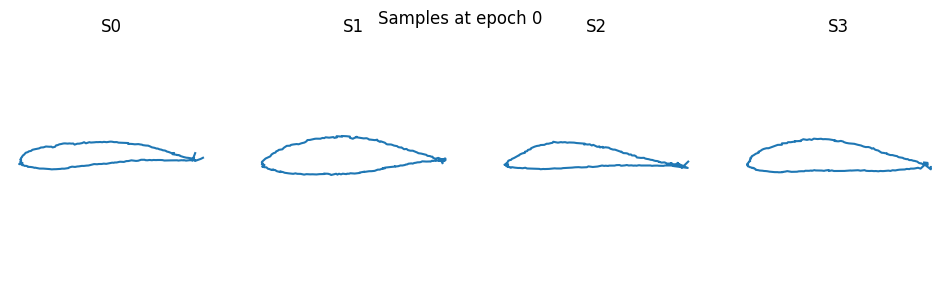

KeyboardInterrupt: 

In [34]:
# === TRAINING LOOP with logging, scheduler, plots ========================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# ------------------------------------------------------------------ config
device       = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS       = 500
LR           = 1e-3
BATCH_SIZE   = 128      # already set in loader
VIS_EPOCHS   = 25
MODEL_DIR    = Path("/kaggle/working/model_weights/Simple_DDPM")
MODEL_DIR.mkdir(parents=True, exist_ok=True)

# ------------------------------------------------------------------ model
model = Unet1D(
    dim        = 32,
    dim_mults  = (2,4,8,16),
    channels   = 2,
    dropout    = 0.1
).to(device)

diffusion = GaussianDiffusion1D(
    model,
    seq_length = 192,
    objective  = 'pred_noise',
    timesteps  = 1000
).to(device)

# ------------------------------------------------------------------ train stuff
optimizer = optim.AdamW(model.parameters(), lr=LR)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.75,
                              patience=10, verbose=True)
loss_fn   = nn.L1Loss()
writer    = SummaryWriter(log_dir="/kaggle/working/tb_logs")

epoch_losses = []

# ------------------------------------------------------------------ training
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    pbar = tqdm(loader, desc=f"Epoch {epoch}/{EPOCHS-1}", leave=False)

    for coords_batch, _ in pbar:                      # labels unused for now
        coords_batch = coords_batch.to(device)        # (B,2,192)

        # sample random t and Gaussian noise
        t     = torch.randint(0, diffusion.num_timesteps,
                              (coords_batch.size(0),), device=device).long()
        noise = torch.randn_like(coords_batch)

        x_t  = diffusion.q_sample(coords_batch, t, noise=noise)
        pred = diffusion.model(x_t, t)
        loss = loss_fn(noise, pred)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        pbar.set_postfix(loss=f"{loss.item():.4f}")

    avg_loss = running_loss / len(loader)
    epoch_losses.append(avg_loss)
    writer.add_scalar("Loss/train", avg_loss, epoch)
    scheduler.step(avg_loss)

    # ---------------- visual samples every VIS_EPOCHS ------------------
    if (epoch % VIS_EPOCHS == 0) or (epoch == EPOCHS-1):
        model.eval()
        with torch.no_grad():
            samples_s = diffusion.sample(batch_size=4)      # (4,2,192) scaled
        samples_r = train_ds.inverse_scale_coords(
                        samples_s.permute(0,2,1).cpu().numpy()).transpose(0,2,1)

        fig, ax = plt.subplots(1,4, figsize=(12,3))
        for i in range(4):
            ax[i].plot(samples_r[i,0], samples_r[i,1])
            ax[i].axis('equal'); ax[i].axis('off'); ax[i].set_title(f"S{i}")
        plt.suptitle(f"Samples at epoch {epoch}")
        plt.show()
        writer.add_figure("Samples", fig, epoch)
        plt.close(fig)

    # ---------------- save checkpoint every 25 epochs ------------------
    if (epoch % 25 == 0) or (epoch == EPOCHS-1):
        torch.save(model.state_dict(), MODEL_DIR / f"model_epoch_{epoch}.pt")

writer.close()

# ---------------- plot loss curve ------------------
plt.figure(figsize=(8,5))
plt.plot(epoch_losses, label="train loss")
plt.xlabel("epoch"); plt.ylabel("L1"); plt.title("Training Loss"); plt.legend(); plt.show()
